# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024

In [1]:
# Packages needed generally
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [3]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [4]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [6]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

In [7]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

In [8]:
ds_20C_mean=ds_20C.mean(dim="member_id")

In [9]:
ds_20C_mean.TEMP.sel(time=slice("1950", "2000"))

<xarray.DataArray 'TEMP' (time: 612, z_t: 60, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(612, 60, 384, 320), dtype=float32, chunksize=(6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [10]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [11]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
995,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
996,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1023,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1030,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
517087,CMIP,MIROC,MIROC-ES2L,historical,r26i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517088,CMIP,MIROC,MIROC-ES2L,historical,r26i1p1f2,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517138,CMIP,MIROC,MIROC-ES2L,historical,r24i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517139,CMIP,MIROC,MIROC-ES2L,historical,r24i1p1f2,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317


In [12]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
79618,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
79938,CMIP,CCCma,CanESM5,historical,r10i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80335,CMIP,CCCma,CanESM5,historical,r13i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80639,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80654,CMIP,CCCma,CanESM5,historical,r13i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
...,...,...,...,...,...,...,...,...,...,...,...
107480,CMIP,CCCma,CanESM5,historical,r16i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107616,CMIP,CCCma,CanESM5,historical,r34i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107630,CMIP,CCCma,CanESM5,historical,r31i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107789,CMIP,CCCma,CanESM5,historical,r32i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [13]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [14]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

79618     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
79938     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80335     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80639     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80654     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
                                ...                        
107480    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107616    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107630    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107789    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
142449    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
Name: zstore, Length: 65, dtype: object

In [15]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(215, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his06
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 tos
    variant_label:               r6i1p2f1
    version:                     v20190429
    status:                      2019-11-11;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/81dad4e4-e025-4912-8e05-ea48266...
    version_id:                  v20190429

In [16]:
#for 1950
ds_1950 = ds.tos.sel(time='1950-03')
ds_2000 = ds.tos.sel(time='2000-03')

In [17]:
ds.coords

Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>

## Maybe what we can do is pull a shape file and read the coordinates through here. 

I found this one on NOAA.

<Axes: >

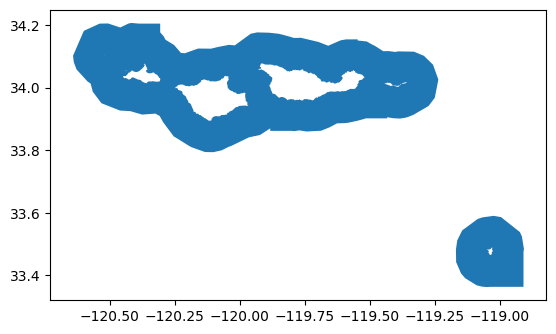

In [19]:
import geopandas as gpd

# Replace 'your_shapefile.shp' with the path to your shapefile
cinms = '../cinms_py'

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

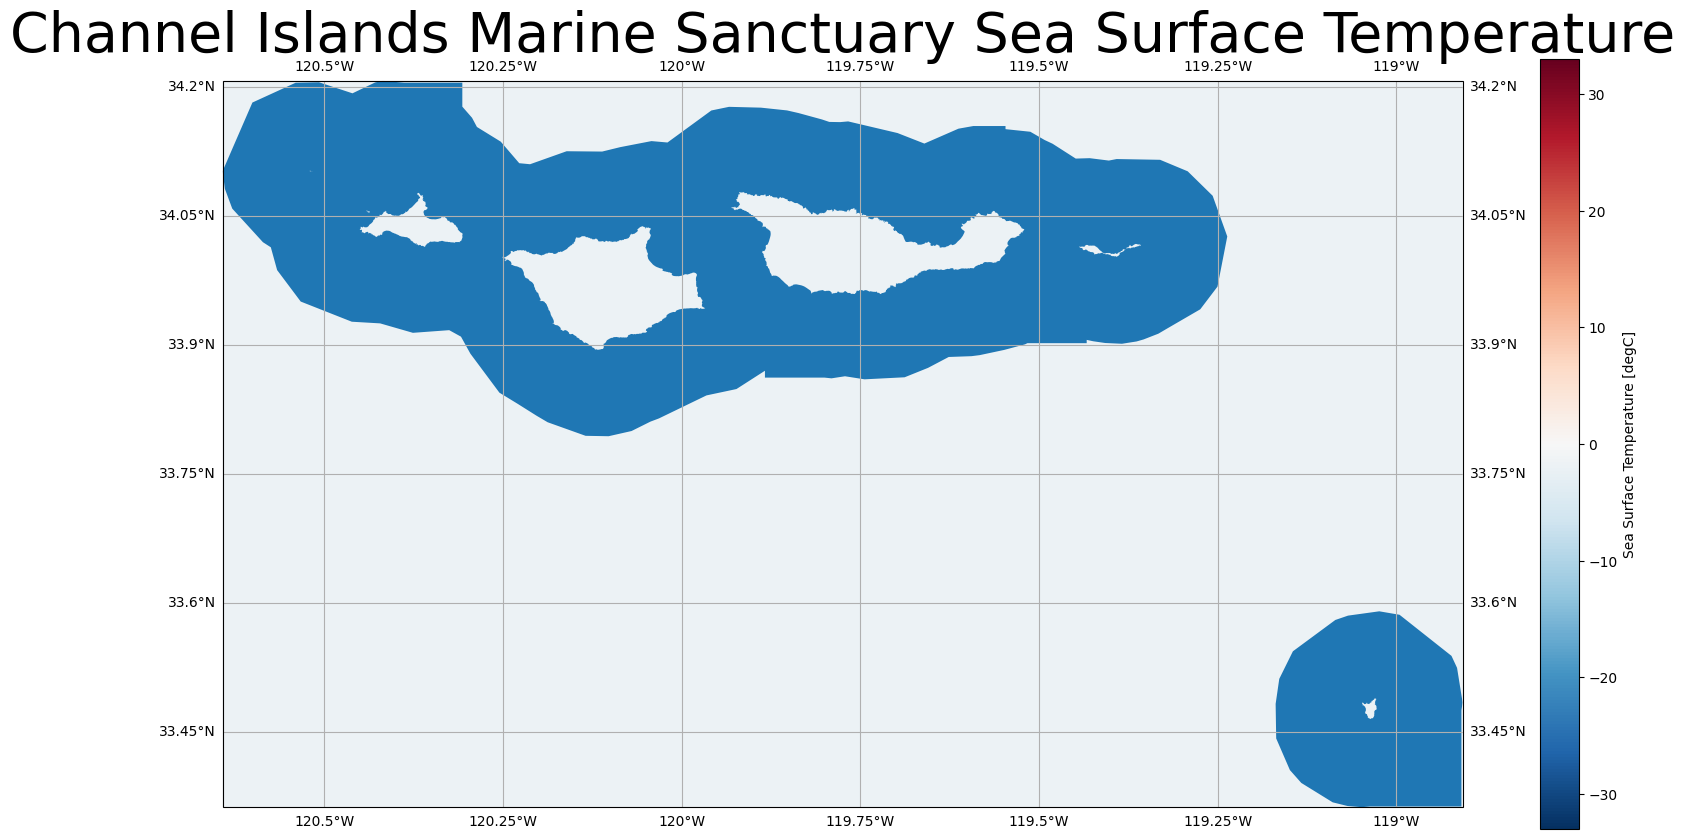

In [21]:
import cartopy.crs as ccrs

# Create a plot
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
ds_1950.plot(ax=ax, # using for ds1
         transform=ccrs.PlateCarree())

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinms_shape.total_bounds[0], cinms_shape.total_bounds[2], cinms_shape.total_bounds[1], cinms_shape.total_bounds[3]])

# Plot the shapefile
cinms_shape.plot(ax=ax)

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature', size = 40)

# Show the plot
plt.show()

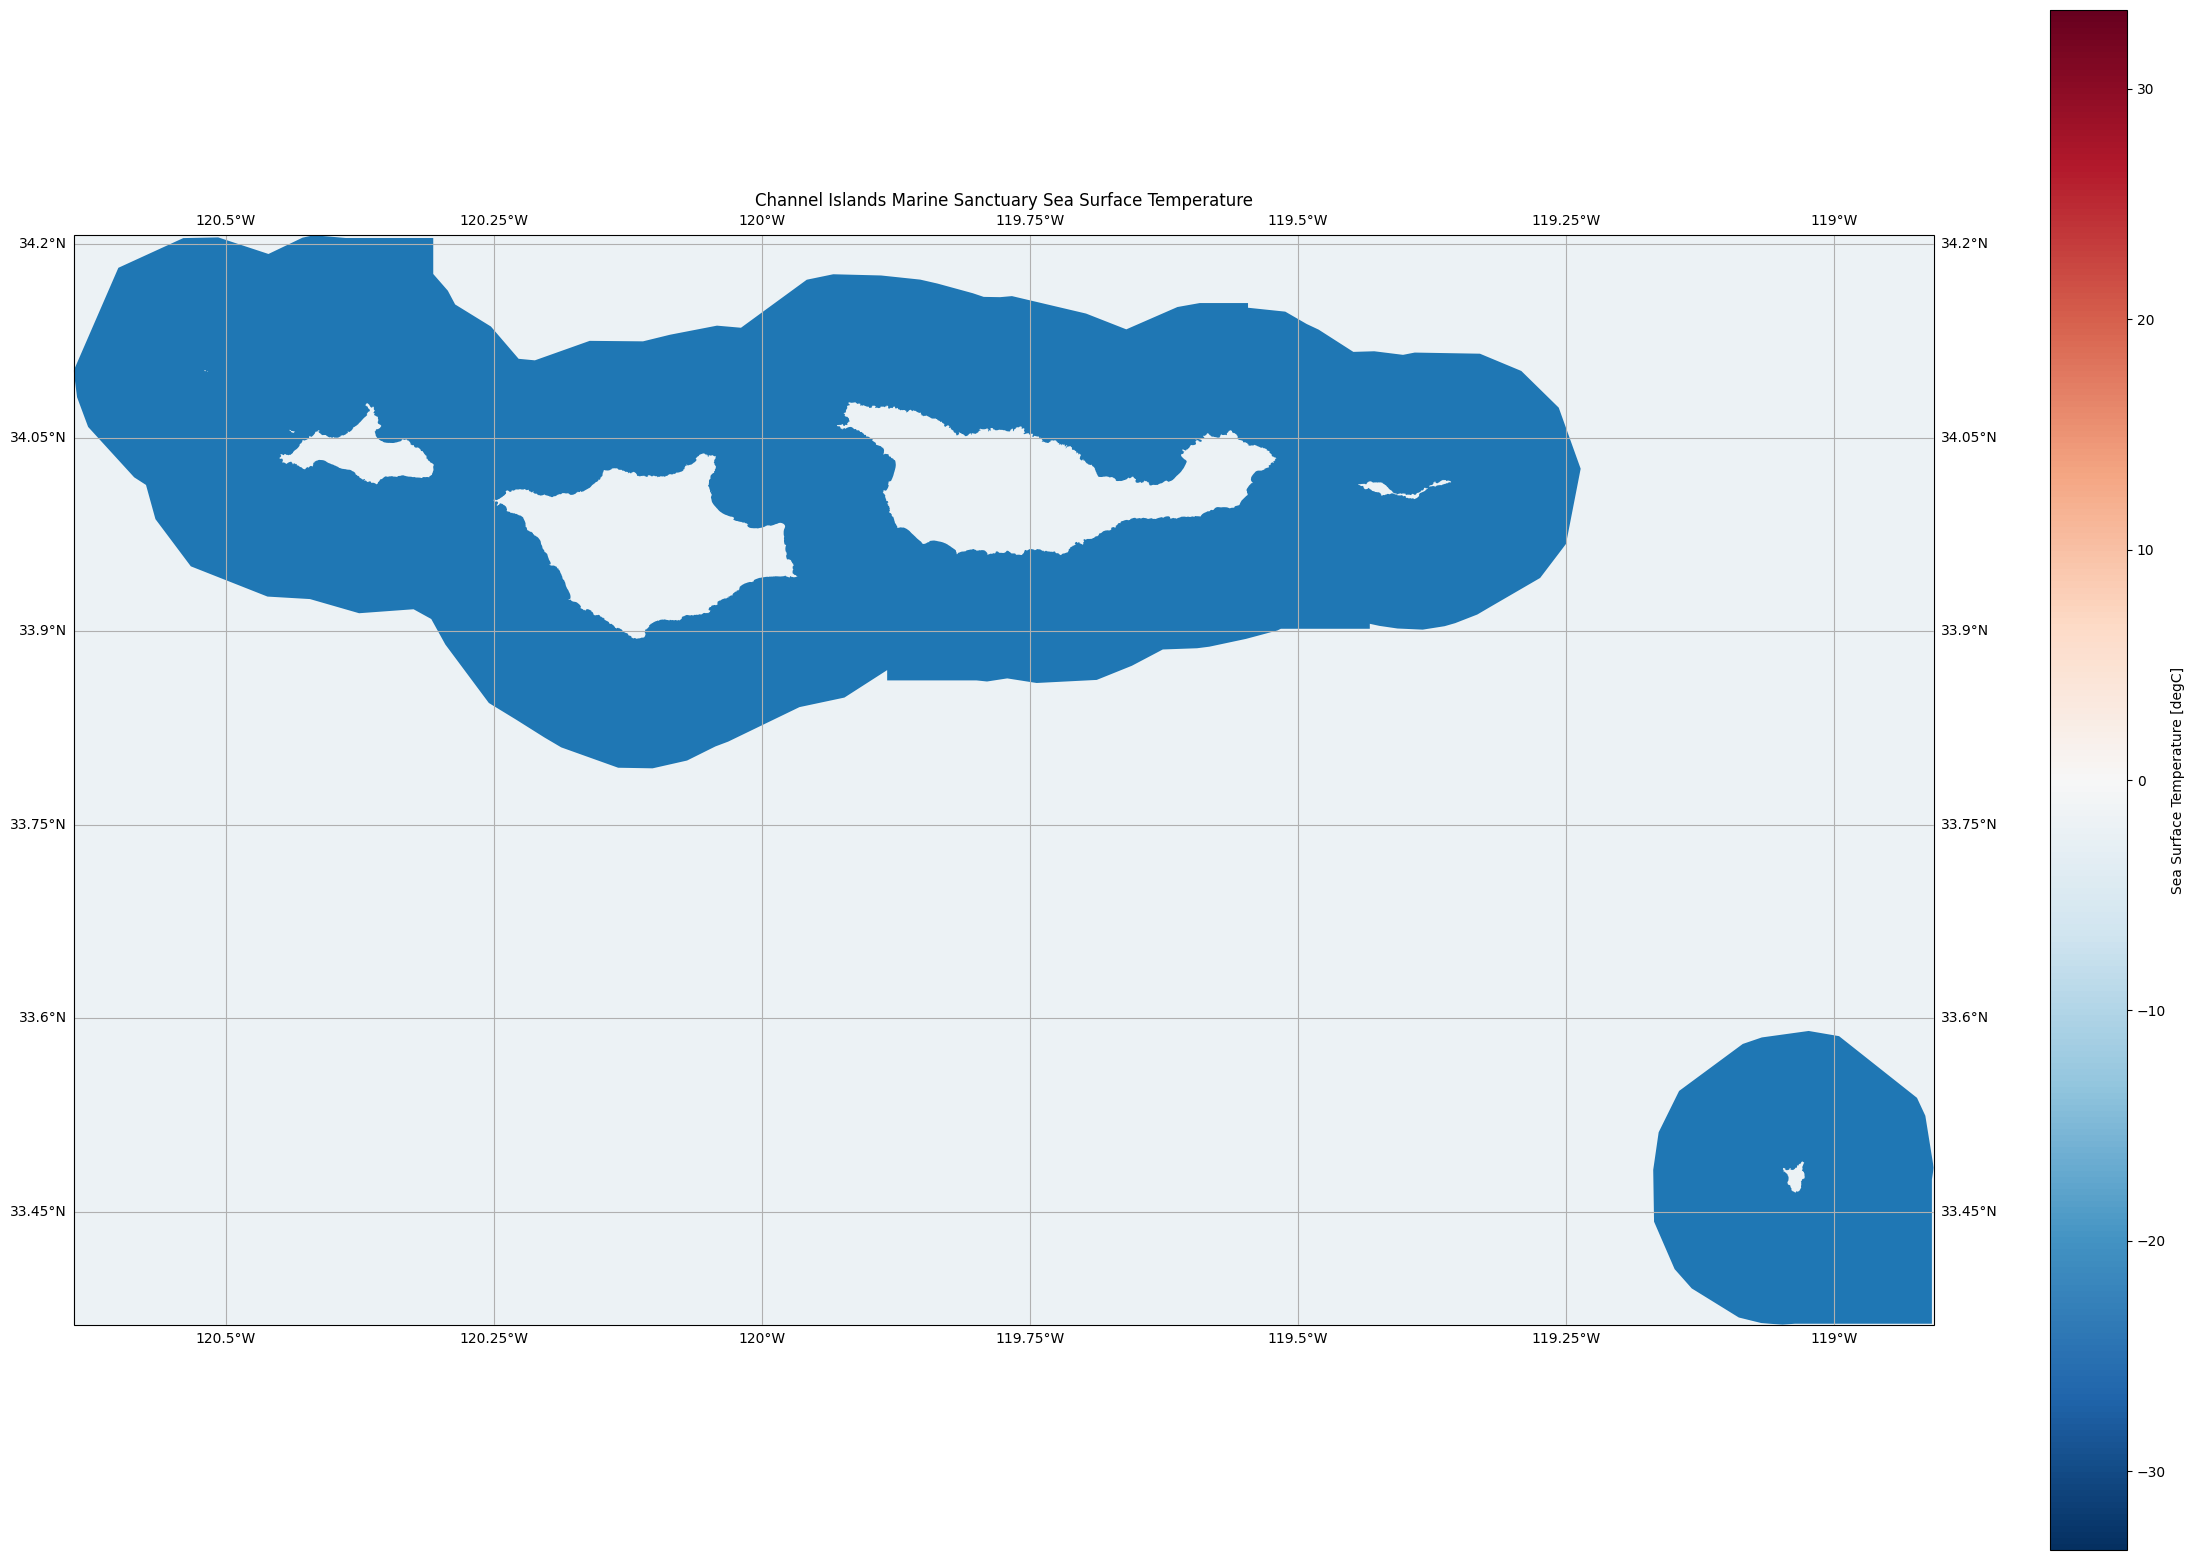

In [22]:
# Create a plot
fig, ax = plt.subplots(figsize=(30, 20), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
ds_2000.plot(ax=ax, # using for ds1
         transform=ccrs.PlateCarree())

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinms_shape.total_bounds[0], cinms_shape.total_bounds[2], cinms_shape.total_bounds[1], cinms_shape.total_bounds[3]])

# Plot the shapefile
cinms_shape.plot(ax=ax)

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# Show the plot
plt.show()